In [1]:
!pip install langchain_core langgraph streamlit
!pip install -U transformers accelerate bitsandbytes torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 135.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 149.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2

In [3]:
# from google.colab import userdata
# HF_TOKEN = userdata.get("HF_TOKEN")


In [4]:
%%writefile app.py
from typing import TypedDict, List, Dict, Union
from langchain_core.messages import HumanMessage, AIMessage
# from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
# from dotenv import load_dotenv
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import os
import numpy as np
import pandas as pd

model_id = "meta-llama/Llama-3.2-3B-Instruct"
# from google.colab import userdata
# HF_TOKEN = userdata.get("HF_TOKEN")

from dotenv import load_dotenv

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")

generator = pipeline(
    "text-generation",
    model=model_id,
    device_map="auto",
    dtype=torch.bfloat16,
    token=HF_TOKEN
)


import sqlite3



def get_patient_info(patient_id):
  # conn = sqlite3.connect("patient_clients.db")
  # cursor = conn.cursor()

  # cursor.execute("SELECT * FROM bio WHERE patient_id = 'patient_id', (50,) ")
  # row = cursor.fetchall()
  row = "35 year old Male"

  # conn.close()
  return row




# latest_patient_response = []

counter = 0
patient_id = ""

class AgentState(TypedDict):
  messages: List[Dict]
  running_notes: str
  current_question: str
  patient_response: str
  system_questions: List[Dict]
  differentials_list: str
  plan: str
  # more_info: bool

def get_profile_info(state: AgentState)->AgentState:
  """This function is a node that gets the patient demographic information and medical history from the database."""
  pt_info = get_patient_info(st.session_state.patient_id)
  state['messages'].append({"role":"user", "content":pt_info})
  state['running_notes'] = pt_info
  return state




def decide_questions_to_ask(state: AgentState)->AgentState:
  """This function decides which question to ask using an LLM"""
  response = generator(state['messages'], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  state['system_questions'].append({response})
  state['current_question'] = response
  return state


def ask_question_get_answer(state: AgentState)->AgentState:
  """This funtion asks the questions to the patient and gets the answers"""
  # patient_response = st.text_area("Write you answers here:", height=180, placeholder="Your answers here: ")
  # latest_patient_response.append(patient_response)
  with st.form("Chat"):
    st.write(state['current_question'])
    user_input = st.text_input("Write Answers here:")
    submitted = st.form_submit_button("Enter")
    if submitted and user_input:
      if len(latest_patient_response)>0:
        state['patient_response'] = latest_patient_response[-1]
        latest_patient_response.pop(0)
  return state


def compile_notes(state: AgentState)->AgentState:
  """This combines the current medical history available in the current notes with the answer that the patient has just provided"""
  compile_notes_prompt = f"As an expert physician that pays attention to detail. Combine the following history {state['running_notes']} and these answers {state['patient_response']} provided by the patient to these questions {state['current_question']}"
  state['running_notes'] = generator([{"role":"user", "content": compile_notes_prompt}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state


def is_more_info_needed(state: AgentState)->bool:
  """Decide if this info is needed to be able to make a good plan for the patient"""
  # global counter
  prompt_full_history = f"Answer with 'Yes' or 'No' only. Is this medical history detailed enough to make a good differential diagnosis and then a plan? {state['running_notes']}"
  if st.session_state.counter > 10:
    return "No"
  else:
    st.session_state.counter += 1
    decision = generator([{"role":"user", "content": prompt_full_history}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
    print(f"This is the decision on whether more information is needed: {decision}")
    if decision.lower() is True:
      return "Yes"
    else:
      return "No"

def list_possible_differentials(state: AgentState)->AgentState:
  """This function creates a list of differential diagnosis based on the list"""
  system_prompt_for_differential = f"You are an expert physician, you have to provide a differential diagnosis for the provided medical history"
  user_prompt_for_differential = state['running_notes']
  state['differentials_list'] = generator([{"role": "system", "content":system_prompt_for_differential},{"role":"user", "content":user_prompt_for_differential}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state


def create_plan(state: AgentState)->AgentState:
  # Need RAG with a directory of physicians
  """This function creates a plan based on the history and the differential diagnosis list"""
  system_prompt_for_plan = f"You have to provide medical advise to this individual. Always insist that the patient needs to seek medical advice. Advise which specialty the patient needs to see. Do not provide definitive medical treatment but suggest what the patient should expect when they go to see a physician"
  user_prompt_for_plan = state['running_notes'] + state["differentials_list"]
  state['plan'] = generator([{"role": "system", "content":system_prompt_for_plan},{"role":"user", "content":user_prompt_for_plan}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state

graph = StateGraph(AgentState)
graph.add_node("get_profile_info", get_profile_info)
graph.add_node("decide_questions_to_ask", decide_questions_to_ask)
graph.add_node("ask_question_get_answer", ask_question_get_answer)
graph.add_node("compile_notes", compile_notes)
graph.add_node("is_more_info_needed", lambda state:state)
graph.add_node("list_possible_differentials", list_possible_differentials)
graph.add_node("create_plan", create_plan)


graph.add_edge(START, "get_profile_info")
graph.add_edge("get_profile_info", "decide_questions_to_ask")
graph.add_edge("decide_questions_to_ask", "ask_question_get_answer")
graph.add_edge("ask_question_get_answer", "compile_notes")
graph.add_edge("compile_notes", "is_more_info_needed")
graph.add_conditional_edges(
    "is_more_info_needed",
    is_more_info_needed,
    {
       "Yes": "decide_questions_to_ask",
       "No": "list_possible_differentials",
    }
)

graph.add_edge("list_possible_differentials", "create_plan")
graph.add_edge("create_plan", END)
agent = graph.compile()


import streamlit as st
# conversation_history = []
if "conversation_history" not in st.session_state:
  st.session_state.conversation_history = []

if "questions" not in st.session_state:
  st.session_state.questions = []
if "latest_patient_response" not in st.session_state:
  st.session_state.latest_patient_response = []

if "current_question" not in st.session_state:
  st.session_state.current_question = []

if "latest_patient_response" not in st.session_state:
  st.session_state.latest_patient_response = []
if "patient_id" not in st.session_state:
  st.session_state.user_id = 1

if "counter" not in st.session_state:
  st.session_state.counter = 0

# conversation_history.append(HumanMessage(content="You are an expert pysician taking history from a new patient. You have to ask more questions to get full details of the illness. Gather the information systematically in a step by step fashion"))
# questions = []
st.header("Thuso App")
st.subheader(f"May you please let me know what is your main concern today")
# user_input = input("Enter: ")
# if user_input := st.chat_input("Write Answers here:"):
#     with st.chat_message("user"):
#         st.write(user_input)
#         if user_input:
with st.form("Chat"):
  user_input = st.text_input("Write Answers here:")
  submitted = st.form_submit_button("Enter")
  if submitted and user_input:
    st.session_state.conversation_history.append({"role":"system", "content":"You are an expert pysician taking history from a new patient. You have to ask more questions to get full details of the illness. Gather the information systematically in a step by step fashion"})

    st.session_state.conversation_history.append({"role":"user", "content":user_input})

    result = agent.invoke({"messages": st.session_state.conversation_history, "system_questions": st.session_state.questions, "running_notes": "","current_question":"", "patient_response":""},)
    conversation_history = result['messages']

    st.caption(f"{result[-1]['plan']}")
  # user_input = input("Enter: ")
    # user_input = st.text_input("Write Answers here:")
    # st.session_state.latest_patient_response.append(user_input)




Writing app.py


In [5]:
# from typing import TypedDict, List, Dict, Annotated, Sequence
# from  langgraph.graph import StateGraph, START, END
# import torch
# from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
# from langchain_core.tools import tool
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode
# from transformers import pipeline
# from google.colab import userdata
# HF_TOKEN = userdata.get("HF_TOKEN")


In [6]:
!npm install localtunnel
# !npm audit fix --force

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 22 packages in 1s
⠙
⠙3 packages are looking for funding
⠙  run `npm fund` for details
⠙npm notice
npm notice New major version of npm available! 10.8.2 -> 11.7.0
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.7.0
npm notice To update run: npm install -g npm@11.7.0
npm notice
⠙

In [7]:
# import urllib.request
# print(urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip())

In [ ]:
!streamlit run /content/app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.12.67.194
⠙your url is: https://early-streets-march.loca.lt


In [ ]:
# !streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0


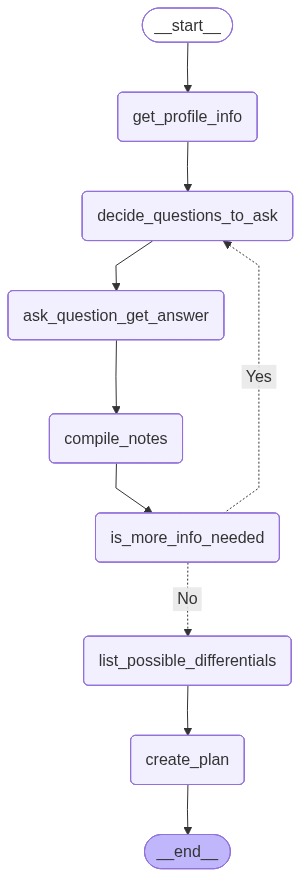

In [1]:
from typing import TypedDict, List, Dict, Union, Annotated
from langchain_core.messages import HumanMessage, AIMessage
# from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
# from dotenv import load_dotenv
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import os
import numpy as np
import pandas as pd
model_id = "meta-llama/Llama-3.2-3B-Instruct"
# from google.colab import userdata
# HF_TOKEN = userdata.get("HF_TOKEN")

from dotenv import load_dotenv

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")

generator = pipeline(
    "text-generation",
    model=model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    token=HF_TOKEN
)


import sqlite3



def get_patient_info(patient_id):
  # conn = sqlite3.connect("patient_clients.db")
  # cursor = conn.cursor()

  # cursor.execute("SELECT * FROM bio WHERE patient_id = 'patient_id', (50,) ")
  # row = cursor.fetchall()
  row = "35 year old Male"

  # conn.close()
  return row




latest_patient_response = []
current_question = []
counter = 0
patient_id = [1]

class AgentState(TypedDict):
  messages: List[Dict]
  running_notes: str
  current_question: str
  patient_response: str
  system_questions: List[Dict]
  differentials_list: str
  # more_info: bool

def get_profile_info(state: AgentState)->AgentState:
  """This function is a node that gets the patient demographic information and medical history from the database."""
  pt_info = get_patient_info(patient_id[0])
  state['messages'].append({"role":"user", "content":pt_info})
  state['running_notes'] = pt_info
  return state




def decide_questions_to_ask(state: AgentState)->AgentState:
  """This function decides which question to ask using an LLM"""
  response = generator(state['messages'], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  state['system_questions'].append({response})
  state['current_question'] = response
  return state


def ask_question_get_answer(state: AgentState)->AgentState:
  """This funtion asks the questions to the patient and gets the answers"""
  # patient_response = st.text_area("Write you answers here:", height=180, placeholder="Your answers here: ")
  # latest_patient_response.append(patient_response)
  if len(latest_patient_response)>0:
    state['patient_response'] = latest_patient_response[-1]
    latest_patient_response.pop(0)
  return state


def compile_notes(state: AgentState)->AgentState:
  """This combines the current medical history available in the current notes with the answer that the patient has just provided"""
  compile_notes_prompt = f"As an expert physician that pays attention to detail. Combine the following history {state['running_notes']} and these answers {state['patient_response']} provided by the patient to these questions {state['current_question']}"
  state['running_notes'] = generator([{"role":"user", "content": compile_notes_prompt}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state


def is_more_info_needed(state: AgentState)->bool:
  """Decide if this info is needed to be able to make a good plan for the patient"""
  global counter
  prompt_full_history = f"Answer with 'Yes' or 'No' only. Is this medical history detailed enough to make a good differential diagnosis and then a plan? {state['running_notes']}"
  if counter > 10:
    return "No"
  else:
    counter += 1
    decision = generator([{"role":"user", "content": prompt_full_history}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
    print(f"This is the decision on whether more information is needed: {decision}")
    if decision.lower() is True:
      return "Yes"
    else:
      return "No"

def list_possible_differentials(state: AgentState)->AgentState:
  """This function creates a list of differential diagnosis based on the list"""
  system_prompt_for_differential = f"You are an expert physician, you have to provide a differential diagnosis for the provided medical history"
  user_prompt_for_differential = state['running_notes']
  state['differentials_list'] = generator([{"role": "system", "content":system_prompt_for_differential},{"role":"user", "content":user_prompt_for_differential}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state


def create_plan(state: AgentState)->AgentState:
  # Need RAG with a directory of physicians
  """This function creates a plan based on the history and the differential diagnosis list"""
  system_prompt_for_plan = f"You have to provide medical advise to this individual. Always insist that the patient needs to seek medical advice. Advise which specialty the patient needs to see. Do not provide definitive medical treatment but suggest what the patient should expect when they go to see a physician"
  user_prompt_for_plan = state['running_notes'] + state["differentials_list"]
  state['plan'] = generator([{"role": "system", "content":system_prompt_for_plan},{"role":"user", "content":user_prompt_for_plan}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state

graph = StateGraph(AgentState)
graph.add_node("get_profile_info", get_profile_info)
graph.add_node("decide_questions_to_ask", decide_questions_to_ask)
graph.add_node("ask_question_get_answer", ask_question_get_answer)
graph.add_node("compile_notes", compile_notes)
graph.add_node("is_more_info_needed", lambda state:state)
graph.add_node("list_possible_differentials", list_possible_differentials)
graph.add_node("create_plan", create_plan)


graph.add_edge(START, "get_profile_info")
graph.add_edge("get_profile_info", "decide_questions_to_ask")
graph.add_edge("decide_questions_to_ask", "ask_question_get_answer")
graph.add_edge("ask_question_get_answer", "compile_notes")
graph.add_edge("compile_notes", "is_more_info_needed")
graph.add_conditional_edges(
    "is_more_info_needed",
    is_more_info_needed,
    {
       "Yes": "decide_questions_to_ask",
       "No": "list_possible_differentials",
    }
)

graph.add_edge("list_possible_differentials", "create_plan")
graph.add_edge("create_plan", END)
agent = graph.compile()





from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

### TO-DO
1. Adjust database querries
2. Implement safety filters (LLM, Text Classifier for Halucinations, Regex)
3. Create good GUI
4. Display Running Conversation on screen
5. Implement and API
6. Dockerize
7. Create Tests

  a. Unit Tests with pytest

  b. Safety Tests
    i. Regex,

  c. Prompt Injection attacks
  
8. GitHub Actions
9. Implement RAG for referring patients, Guidelines e.g. EDLIZ, History Taking Checklist